# Fraud Detection with Variational Autoencoder

- VAE는 vanilla 오토인코더에 비해 훨씬 나은 성능의 이상탐지(anomaly detection) 성능을 제공합니다. 실험을 통해 우리는 기존의 AE는 너무 큰 bottleneck을 가지면 identity function(주어진 입력을 그대로 출력하는 함수)이 되며 이상탐지 성능이 떨어지는 것에 반해, VAE는 bottleneck의 크기가 커질수록 이상탐지 성능이 오르는 효과를 갖는 것을 확인할 수 있습니다. 따라서 AE 기반의 anomaly detection을 수행할 때, 기존에는 bottleneck의 크기를 hyper-parameter로 튜닝해야 했던 반면에, VAE의 경우에는 튜닝을 할 필요가 거의 없습니다.  

- 신용 카드 데이터에 VAE(Variational Autoencoder)를 적용합니다.


- 분포를 배우는 것이 좋은 점은,  
    첫째, 데이터 및 노이즈 생성 프로세스를 명시적으로 모델링함으로써 VAE는 더 robust 하게 그 두가지를 분리하는 방법을 배울 수 있습니다.   
    둘째, disentanglement constraint가 적용되면 잠재 공간이 더 해석 가능해집니다.    
    셋째, 잠재 벡터를 샘플링하여 새 샘플을 생성하고 디코더를 통해 새로운 데이터를 생성할 수 있습니다.
    
     disentanglement : latent space가 linear한 구조를 가지게 되어서 하나의 latent vector z 를 움직였을 때 정해진 어떠한 하나의 특성이 변경되게 만들고자 하는 것. "Disentanglement constraint"는 이러한 독립적이고 해석 가능한 잠재 표현을 학습하도록 네트워크에 적용되는 제약.

### Contents

1. Variational Autoencoder 훈련
2. 잠재 표현 시각화 (Visualize Latent Representations)
3. VAE model 훈련
4. 재구성 오류 계산
5. 테스트 세트에 대한 평가

In [1]:
!pip install tensorflow==2.15.0

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, \
                            precision_score, recall_score
from sklearn.preprocessing import StandardScaler

np.random.seed(0)
tf.random.set_seed(0)

## Raw Dataset

model train 은 train set 만으로 합니다. test set은 최종 평가 때까지 사용되지 않습니다.

In [3]:
df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


-  데이터 세트가 매우 불균형합니다.

In [4]:
# 'Class' 열에 있는 각 값의 개수를 count 합니다.
df['Class'].value_counts()

,count
Class,
0,284315
1,492


In [5]:
# 'Class' 열에서 사기(Fraud) 거래의 개수를 셉니다. 'Class'가 1인 경우가 사기 거래를 의미합니다.
fraud = (df['Class'] == 1).sum()

# 'Class' 열에서 정상(Normal) 거래의 개수를 셉니다. 'Class'가 0인 경우가 정상 거래를 의미합니다.
normal = (df['Class'] == 0).sum()

# 사기 거래와 정상 거래의 전체 개수를 계산합니다.
total = fraud + normal

# 전체 거래 수를 출력합니다. 콤마(,)는 천 단위 구분을 위한 것입니다.
print(f"Total = {total:,}")

# 사기 거래의 비율을 계산하여 퍼센트(%)로 출력합니다.
print(f"Fraud = {fraud/total*100:,.2f}%")

# 정상 거래의 비율을 계산하여 퍼센트(%)로 출력합니다.
print(f"Normal = {normal/total*100:,.2f}%")

Total = 284,807
Fraud = 0.17%
Normal = 99.83%


- Time 필드를 일중 시간으로 변환합니다.   
- Amount 필드는 로그 스케일로 변환합니다.

In [6]:
df.loc[:, "Time"]   = df.loc[:, "Time"].apply(lambda x : x / 3600 % 24) #24 시간
df.loc[:, 'Amount'] = np.log(df.loc[:, 'Amount'] + 1)

- class 1 이 너무 적으므로 통상적인 7:3 대신 5:5 비율로 train, test set 분리

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
                        df.drop('Class', axis=1), df['Class'],
                        test_size=0.5, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((142403, 30), (142404, 30), (142403,), (142404,))

In [8]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train.values)
X_test  = sc.transform(X_test.values)

In [9]:
# y_train 데이터에서 각 클래스의 비율 계산
y_train.value_counts() / y_train.count()

,count
Class,
0,0.998251
1,0.001749


In [10]:
# y_test 데이터에서 각 클래스의 비율 계산
y_test.value_counts() / y_test.count()

,count
Class,
0,0.998294
1,0.001706


## Variational Autoencoder 훈련

- 디코더의 출력인 데이터 분포 매개 변수는 정규 분포를 따릅니다.  신용카드 데이터는 실수 값이며 일반적으로 정규 분포를 따르므로 정규 분포를 사용하여 출력을 모델링하는 것이 합리적입니다.

train set 을 정상과 비정상 set 으로 구분

In [11]:
# y_train이 0인 데이터(정상 거래)만 선택하여 X_train_normal에 저장
X_train_normal = X_train[y_train == 0]

# y_train이 1인 데이터(사기 거래)만 선택하여 X_train_fraud에 저장
X_train_fraud = X_train[y_train == 1]

X_train_normal.shape, X_train_fraud.shape

((142154, 30), (249, 30))

test set을 정상과 비정상 set으로 구분

In [12]:
# y_test가 0인 데이터(정상 거래)만 선택하여 X_test_normal에 저장
X_test_normal = X_test[y_test == 0]

# y_test가 1인 데이터(사기 거래)만 선택하여 X_test_fraud에 저장
X_test_fraud = X_test[y_test == 1]

X_test_normal.shape, X_test_fraud.shape

((142161, 30), (243, 30))

### 데이터 파이프라인 작성

In [13]:
# X_train_normal 데이터셋을 텐서로 변환한 후, tf.data.Dataset 객체로 만듭니다.
train_ds = tf.data.Dataset.from_tensor_slices(X_train_normal).shuffle(10000).batch(128)

# X_test_normal 데이터셋을 텐서로 변환한 후, tf.data.Dataset 객체로 만듭니다.
test_ds = tf.data.Dataset.from_tensor_slices(X_test_normal).batch(128)

## 신경망 구조 정의

<img src="https://i.imgur.com/auIX6vL.png" WIDTH=600/>

### Sampling Class

먼저 'Sampling' 클래스를 빌드합니다. 이것은 인코더 출력의 평균 (mu) 및 표준 편차 (sigma)와 함께 가우스 노이즈 입력을 제공하는 맞춤형 Keras 레이어입니다. 실제로 이 레이어의 출력은 다음 방정식으로 제공됩니다.

$$z = \mu + e^{0.5\sigma} * \epsilon  $$

여기서 $\mu$ = mean, $\sigma$ = standard deviation, $\epsilon$ = random sample

In [14]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        """인코더의 출력과 결합하여 무작위 샘플을 생성합니다.
        Args:
          inputs -- 인코더로부터의 출력 텐서 (평균 mu, 표준편차 sigma)
        Returns:
          무작위 샘플이 결합된 `inputs` 텐서
        """
        # 인코더의 출력을 분해합니다.
        mu, sigma = inputs

        # 배치의 크기와 차원을 얻습니다.
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]

        # 무작위 텐서를 생성합니다.
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))

        # 재매개변수화 기법을 적용합니다.
        return mu + tf.math.exp(0.5 * sigma) * epsilon

### Kullback–Leibler Divergence
모델의 생성 능력을 향상 시키려면 잠재 공간에 도입된 랜덤 정규 분포를 고려해야 합니다. 이를 위해 [Kullback–Leibler Divergence](https://arxiv.org/abs/2002.07514)가 계산되어 재구성 손실에 추가됩니다. 공식은 아래 함수에서 정의됩니다.

In [15]:
def kl_reconstruction_loss(inputs, outputs, mu, sigma):
    """Kullback-Leibler 발산(KLD) 계산
    Args:
    inputs -- 데이터셋 배치
    outputs -- Sampling 층의 출력
    mu -- 평균
    sigma -- 표준 편차

    Returns:
    KLD 손실
    """
    # KLD 계산 공식 적용
    kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
    # 배치 내 평균을 계산하고 -0.5를 곱하여 최종 KLD 손실을 계산
    kl_loss = tf.reduce_mean(kl_loss) * -0.5

    return kl_loss

### VAE Model
이제 전체 VAE 모델을 정의할 수 있습니다. KL reconstruction loss를 추가하기 위해 `model.add_loss()`를 사용합니다. 이 손실을 계산하는 것은 `y_true`와 `y_pred`를 사용하지 않으므로 `model.compile()`에서 사용할 수 없습니다.

- add_loss() 메서드 : 손실이 있는 경우, 자동으로 합산되어 주 손실에 추가

In [16]:
# 잠재 공간의 차원을 2로 설정합니다. 즉, 인코더는 입력 데이터를 2차원의 잠재 벡터로 압축합니다.
LATENT_DIM = 2

# X_train_normal 데이터셋의 특징(피처) 수를 입력 데이터의 차원으로 설정합니다.
input_dim = X_train_normal.shape[-1]

### Encoder 정의

In [17]:
# 인코더의 입력 레이어를 정의
encoder_input = Input(shape=(input_dim,))
# 은닉층을 정의합니다.
x = Dense(32, activation='relu')(encoder_input)
x = Dense(16, activation='relu')(x)

# 잠재 변수의 평균을 나타내는 mu 레이어 정의
mu = Dense(LATENT_DIM)(x)

# 잠재 변수의 표준 편차를 나타내는 sigma 레이어 정의
sigma = Dense(LATENT_DIM)(x)

# 샘플링 레이어를 통해 잠재 벡터 z를 샘플링합니다.
z = Sampling()((mu, sigma))  # mu와 sigma를 사용하여 잠재 공간 z에서 샘플링합니다.

# 인코더 모델을 정의합니다.
encoder = Model(encoder_input, [mu, sigma, z])

### Decoder 정의

In [18]:
# 디코더의 입력 레이어를 정의합니다.
decoder_input = Input(shape=(LATENT_DIM,))

# 은닉층을 정의
x = Dense(16, activation='relu')(decoder_input)
x = Dense(32, activation='relu')(x)

# 출력층을 정의. 원래 입력 데이터 차원으로 복원하며 출력 값을 0과 1 사이로 제한
decoded = Dense(input_dim, activation='sigmoid')(x)

# 디코더 모델을 정의
decoder = Model(decoder_input, decoded)

### 변이형 오토인코더(VAE, Variational Autoencoder)를 구축하고 학습하기 위해 필요한 모델을 정의

In [19]:
vae_input = encoder_input

# 인코더를 통과시켜 평균(mu), 표준 편차(sigma), 그리고 잠재 공간의 벡터(z)를 얻습니다.
mu, sigma, z = encoder(vae_input)
# 디코더를 사용하여 잠재 공간의 벡터(z)로부터 입력을 재구성
reconstructed = decoder(z)

# 입력과 재구성된 값을 사용하여 VAE 모델을 생성
vae = Model(vae_input, reconstructed)
# Kullback-Leibler 발산을 계산하는 함수를 사용하여 손실을 추가합니다. 이는 잠재 공간의 분포가
# 우리가 원하는 분포(예: 표준 정규 분포)에 가까워지도록 돕습니다.
loss = kl_reconstruction_loss(vae_input, z, mu, sigma)
# add_loss는 사용자 정의 손실을 추가하는 메서드
vae.add_loss(loss)

In [20]:
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

# 학습 과정에서의 평균 손실을 추적
loss_metric = tf.keras.metrics.Mean()
# 평균 제곱 오차 손실 함수를 사용합니다.
mse_loss = tf.keras.losses.MeanSquaredError()

In [21]:
s = time.time()

epochs = 50

@tf.function
def train_step(x_batch_train):
    with tf.GradientTape() as tape:
        # VAE 모델에 배치 입력을 공급하여 재구성된 결과를 얻음
        reconstructed = vae(x_batch_train)

        # 재구성 손실을 계산
        loss = mse_loss(x_batch_train, reconstructed)

        # KLD 정규화 손실을 추가
        loss += sum(vae.losses)  # vae.losses에는 KLD 손실이 포함됨

    # 그라디언트를 계산하고 가중치 업데이트
    grads = tape.gradient(loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(grads, vae.trainable_weights))
    return loss

# 테스트 스텝 추가
@tf.function
def test_step(x_batch_test):
    reconstructed = vae(x_batch_test)
    loss = mse_loss(x_batch_test, reconstructed)
    loss += sum(vae.losses)
    return loss

# 손실 지표를 두 개로 분리
train_loss_metric = tf.keras.metrics.Mean()
test_loss_metric = tf.keras.metrics.Mean()

for epoch in range(epochs):
    print('Start of epoch %d' % (epoch,))

    # 에포크 시작 시 지표 리셋
    train_loss_metric.reset_states()
    test_loss_metric.reset_states()

    for step, (x_batch_train, x_batch_test) in enumerate(zip(train_ds, test_ds)):
        # 훈련 스텝
        train_loss = train_step(x_batch_train)
        train_loss_metric(train_loss)

        # 테스트 스텝
        test_loss = test_step(x_batch_test)
        test_loss_metric(test_loss)

        # 매 500 스텝마다 결과 표시
        if step % 500 == 0:
            print('Epoch: %s step: %s' % (epoch, step))
            print('Mean training loss = %s' % (train_loss_metric.result().numpy()))
            print('Mean test loss = %s' % (test_loss_metric.result().numpy()))

Start of epoch 0
Epoch: 0 step: 0
Mean training loss = 20.794827
Mean test loss = 1.7380562
Epoch: 0 step: 500
Mean training loss = 3.2655063
Mean test loss = 1417092.9
Epoch: 0 step: 1000
Mean training loss = 8.953997
Mean test loss = 709254.56
Start of epoch 1
Epoch: 1 step: 0
Mean training loss = 1.0192984
Mean test loss = 1.1184138
Epoch: 1 step: 500
Mean training loss = 1.2674577
Mean test loss = 441.65747
Epoch: 1 step: 1000
Mean training loss = 1.8394066
Mean test loss = 221.64383
Start of epoch 2
Epoch: 2 step: 0
Mean training loss = 2.4724462
Mean test loss = 1.0285066
Epoch: 2 step: 500
Mean training loss = 1.1503242
Mean test loss = 39.15303
Epoch: 2 step: 1000
Mean training loss = 1.5061868
Mean test loss = 20.14583
Start of epoch 3
Epoch: 3 step: 0
Mean training loss = 0.9447164
Mean test loss = 1.0022706
Epoch: 3 step: 500
Mean training loss = 1.0835617
Mean test loss = 3.9044032
Epoch: 3 step: 1000
Mean training loss = 1.2738894
Mean test loss = 2.4771485
Start of epoch 

In [22]:
print(f"경과 시간: {(time.time() - s) / 60} 분")

경과 시간: 6.7716276009877525 분


## Reconstruction Error 시각화

- Anomaly data 와의 bar chart 비교를 위해 정상 abnormal data 갯수 만큼의 임의의 normal sample 을 선택

In [23]:
# 정상 sample 무작위 sampling
idx = np.random.choice(len(X_train_normal), 250, replace=False)
Nom_data = X_train_normal[idx]
Nom_data.shape

(250, 30)

### 정상 data 및 fraud data 의 autoencoder 재 구성값
- 정상 data의 metric

In [24]:
# 정상 데이터의 재구성 결과 값
Nom_pred = vae.predict(Nom_data)
# 재구성 오류 -  input/output 간의 MSE 구하기
Nom_pred_mse = np.mean(np.power(Nom_data - Nom_pred, 2), axis=1)

print('Normal Metric')
Nom_pred_mse_df = pd.DataFrame({'Normal_mse': Nom_pred_mse})
Nom_pred_mse_df.describe()

8/8 [==============================] - 0s 2ms/step
Normal Metric


,Normal_mse
count,250.000000
mean,0.817786
std,0.819106
min,0.225209
25%,0.446974
50%,0.610514
75%,0.950451
max,6.902177


In [25]:
# 비정상 data의 재구성 결과값
ANom_pred = vae.predict(X_train_fraud)
# 재구성 오류 -  input/output 간의 MSE 구하기
ANom_pred_mse = np.mean(np.power(X_train_fraud - ANom_pred, 2), axis=1)

print('Anomaly Metric')
ANom_pred_mse_df = pd.DataFrame({'Anomaly_mse':ANom_pred_mse})
ANom_pred_mse_df.describe()

8/8 [==============================] - 0s 2ms/step
Anomaly Metric


,Anomaly_mse
count,249.000000
mean,24.155042
std,31.095675
min,0.343846
25%,4.418346
50%,9.570654
75%,28.879992
max,198.777847


### MSE 분포 시각화 비교

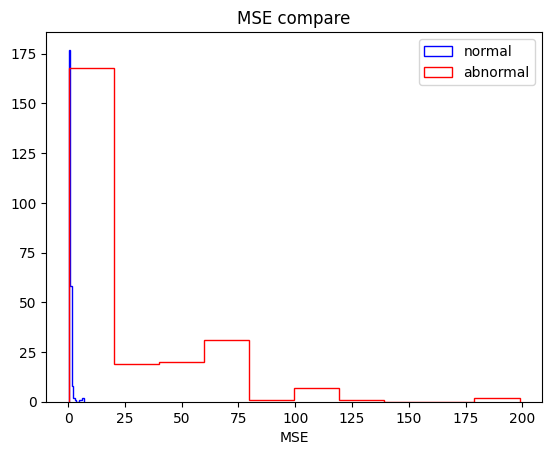

In [26]:
plt.title('MSE compare')
plt.hist(Nom_pred_mse, bins=10, color='blue', histtype='step', label='normal')
plt.hist(ANom_pred_mse, bins=10, color='red', histtype='step', label='abnormal')
plt.xlabel('MSE')
plt.legend()
plt.show()

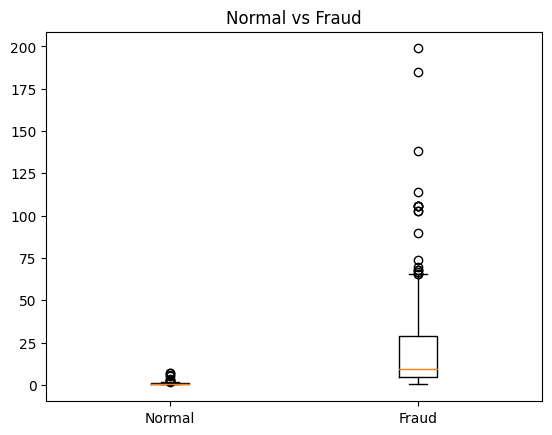

In [27]:
plt.boxplot([Nom_pred_mse, ANom_pred_mse])
plt.title('Normal vs Fraud')
plt.xticks(ticks=[1, 2], labels=['Normal', 'Fraud'])
plt.show()

## 잠재 표현 (Latent Representations) 시각화

In [28]:
X_test.shape

(142404, 30)

In [29]:
latent_x_mean, latent_x_std, latent_x  = encoder(X_test)

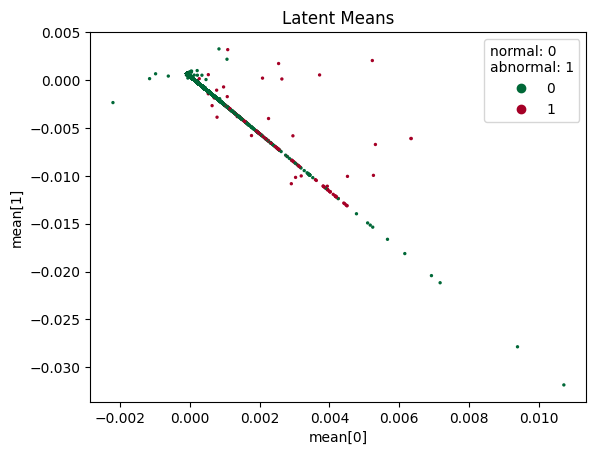

In [30]:
#  X_test의 잠재 공간에서의 평균을 산점도로 그립니다.
ax = plt.scatter(latent_x_mean[:, 0], latent_x_mean[:, 1], c=y_test, cmap='RdYlGn_r', s=2)

# 제목과 축 레이블을 설정합니다.
plt.title('Latent Means')
plt.xlabel('mean[0]')
plt.ylabel('mean[1]')

# 범례 추가: y_test 값에 따라 0은 Normal, 1은 Fraud로 표시합니다.
# 간단히 범례를 추가합니다.
plt.legend(*ax.legend_elements(), title="normal: 0\nabnormal: 1")

# 그래프를 표시합니다.
plt.show()

원점 [0,0] 평균 벡터 주변에서 사기와 사기가 아닌 트랜잭션 사이에는 분명한 구분이 있습니다. 이는 VAE가 의미있는 것을 학습하고 있다는 신호입니다.

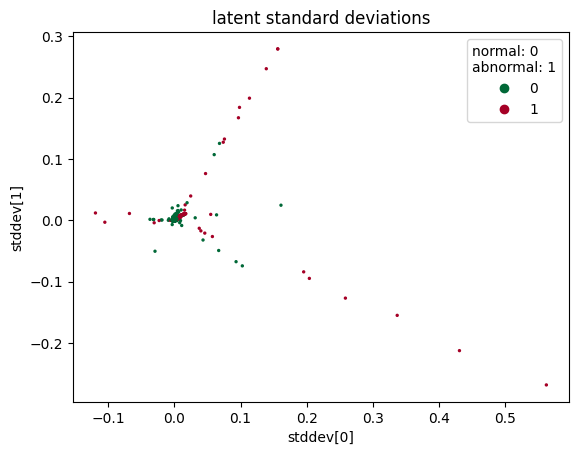

In [31]:
# X_test의 잠재 표현 표준 편차 계산
ax = plt.scatter(latent_x_std[:, 0], latent_x_std[:, 1], c=y_test, cmap='RdYlGn_r', s=2)
plt.title('latent standard deviations')
plt.xlabel('stddev[0]')
plt.ylabel('stddev[1]')
plt.legend(*ax.legend_elements(), title="normal: 0\nabnormal: 1")
plt.show()

빨간색으로 표시된 사기 거래의 표준 편차가 훨씬 더 흩어져 있고 사기 거래가 불규칙한 경향이 있다는 직관과 일치합니다.

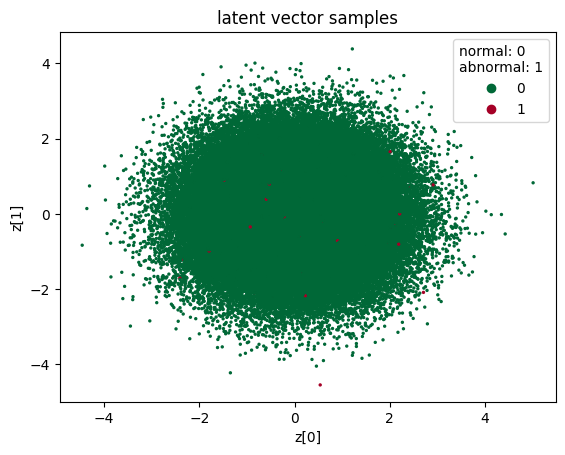

In [32]:
# X_test의 잠재 표현 시각화
ax = plt.scatter(latent_x[:, 0], latent_x[:, 1], c=y_test, cmap='RdYlGn_r', s=2)
plt.title('latent vector samples')
plt.xlabel('z[0]')
plt.ylabel('z[1]')
plt.legend(*ax.legend_elements(), title="normal: 0\nabnormal: 1")
plt.show()

샘플된 잠재 벡터 z입니다. 클러스터링 및 scattering은 이전 관찰과 일치합니다.

##  Reconstruction error threshold
- 정상 data 로만 train 한 vae model 의 재구성 결과의 원본과의 mse 차이를 기준으로 사기 거래 분류

In [33]:
# VAE를 사용하여 train set의 데이터를 재구성(predictions)합니다.
predictions = vae.predict(X_train)

# 원본 데이터(X_train)와 재구성된 데이터(predictions) 간의 평균 제곱 오차(MSE)를 계산
# 각 샘플에 대해 MSE를 계산하여, 재구성 오류를 측정합니다.
mse = np.mean(np.power(X_train - predictions, 2), axis=1)

# 재구성 오류(mse)와 실제 클래스(y_train)를 포함한 데이터프레임을 생성
# 각 샘플의 재구성 오류와 해당 샘플이 정상(0)인지 사기(1)인지 나타내는 레이블을 포함
error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_train})

error_df.head()

4451/4451 [==============================] - 6s 1ms/step


,reconstruction_error,true_class
269414,1.478399,0
75463,0.278134,0
99307,0.262621,0
212267,2.086700,0
157412,0.914189,0


In [34]:
# 'true_class' 값에 따라 정상(0)과 사기(1) 데이터로 그룹한 다음, 각 그룹의 재구성 오류에 대한 기술 통계를 구합니다.
desc = error_df.groupby('true_class').describe()
desc

reconstruction_error                                            \
                          count       mean        std       min       25%   
true_class                                                                  
0                      142154.0   0.959469   2.885683  0.163105  0.439558   
1                         249.0  24.155667  31.096373  0.343902  4.424495   

                                             
                 50%        75%         max  
true_class                                   
0           0.629896   0.932084  264.361192  
1           9.578492  28.879574  198.775442

위에서 보듯 사기성이 아닌 거래의  오류는 사기성 거래 보다 낮습니다.

- mean + 3*std를 threshold로 사용하여 test set의 재구성 error(squared error)가 threshold 보다 크면 fraud 거래로 분류합니다.  
- 1 std - 68%, 2 std - 96%, 3 std - 99.8%

In [35]:
# 정상 클래스(true_class가 0인 데이터)의 재구성 오류에 대한 평균(mean)과 표준 편차(std)를 추출
# desc 데이터프레임에서 'reconstruction_error' 열의 평균과 표준 편차를 가져옵니다.
mean = desc['reconstruction_error']['mean'][0]   # 정상 데이터의 재구성 오류 평균
std = desc['reconstruction_error']['std'][0]            # 정상 데이터의 재구성 오류 표준 편차

# 다양한 임계값(thresholds) 설정. 임계값은 3-sigma, 2.5-sigma, 2-sigma로 설정.
thresholds = {'3sigma': mean + 3*std,
              '2.5sigma': mean + 2.5*std,
              "2sigma": mean + 2*std}

# 계산된 평균, 표준 편차, 그리고 임계값들을 출력
mean, std, thresholds

(0.9594694349218752,
 2.8856831837180548,
 {'3sigma': 9.61651898607604,
  '2.5sigma': 8.173677394217012,
  '2sigma': 6.730835802357984})

- Test set을 이용하여 재구성 오류 계산  
- thrshold 별로 confusion matrix

4451/4451 [==============================] - 7s 1ms/step
Precision 0.10
Recall 0.61


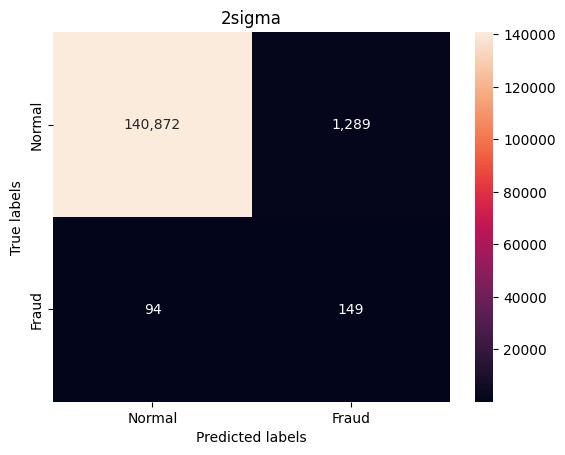

4451/4451 [==============================] - 7s 1ms/step
Precision 0.12
Recall 0.56


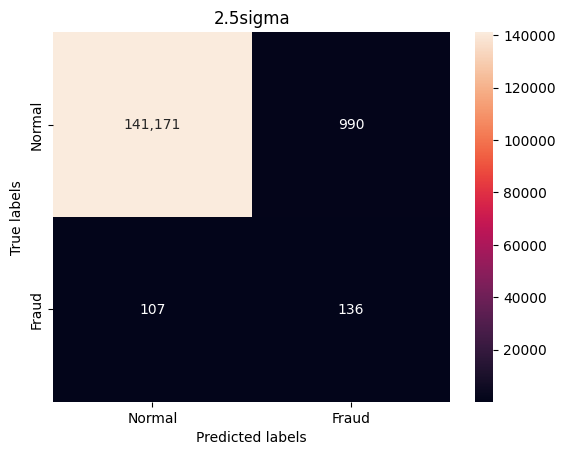

4451/4451 [==============================] - 7s 1ms/step
Precision 0.13
Recall 0.48


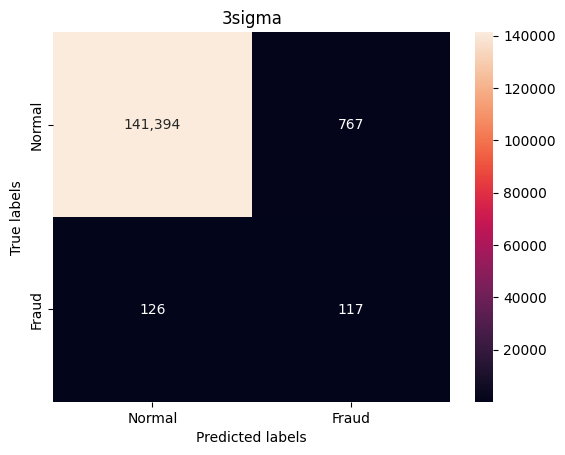

In [36]:
# thresholds 딕셔너리를 value 값 기준으로 오름차순 정렬합니다.
thresholds = sorted(thresholds.items(), key=lambda kv: kv[1])

# 모델의 예측을 수행하는 함수입니다.
# 주어진 임계값(threshold)과 MSE(Mean Squared Error)를 비교하여
# 예측 결과를 반환합니다. MSE가 임계값보다 크면 1(사기), 작으면 0(정상)으로 예측합니다.
def model_predict(threshold, mse):
    predictions = [(lambda er: 1 if er > threshold else 0)(er) for er in mse]
    return predictions

# 각 sigma와 그에 대응하는 threshold 값을 기준으로 모델을 평가합니다.
for sigma, threshold in thresholds:

    # VAE를 사용해 X_test 데이터에 대한 예측을 수행합니다.
    test_predictions = vae.predict(X_test)

    # MSE(Mean Squared Error)를 계산합니다.
    # 각 테스트 샘플에 대해 원본 데이터와 예측 데이터 간의 제곱 오차 평균을 계산합니다.
    mse = np.mean(np.power(X_test - test_predictions, 2), axis=1)

    # 임계값을 사용해 예측 결과를 0 또는 1로 변환합니다.
    y_pred = model_predict(threshold, mse)

    # 정밀도(Precision)와 재현율(Recall)을 계산하고 출력합니다.
    print("Precision {:.2f}".format(precision_score(y_test, y_pred)))
    print("Recall {:.2f}".format(recall_score(y_test, y_pred)))

    # 혼동 행렬(Confusion Matrix)을 계산합니다.
    cm = confusion_matrix(y_test, y_pred)

    # 혼동 행렬을 히트맵으로 시각화합니다.
    ax = sns.heatmap(cm, annot=True, fmt=',')
    ax.set_xlabel('Predicted labels')  # x축 레이블 설정
    ax.set_ylabel('True labels')       # y축 레이블 설정
    ax.xaxis.set_ticklabels(['Normal', 'Fraud'])  # x축 틱 레이블 설정
    ax.yaxis.set_ticklabels(['Normal', 'Fraud'])  # y축 틱 레이블 설정
    ax.set(yticks=[0.5, 1.5], xticks=[0.5, 1.5])  # 틱 위치 설정
    ax.set_title(sigma)  # 히트맵의 제목을 sigma 값으로 설정
    plt.show()  # 히트맵을 표시